In [14]:
import pandas as pd
from scipy.stats import kruskal
import matplotlib.pyplot as plt

df_slurp = pd.read_csv('data/merged_slurp_sed.csv')
df_kf = pd.read_excel('data/kfs-slurp.xlsx', engine='openpyxl')

# Optionally, round 'depth' columns to avoid float precision issues
df_slurp['depth_rounded'] = df_slurp['depth'].round(3)
df_kf['depth_rounded'] = df_kf['depth'].round(3)

df_kf

,Unnamed: 0,sample,site_name,depth,depth_sat_zone,wl_only_unsat,Wooster et al. (2008) [Estimated kf],depth_rounded
0,0,A-1,A,0.86,0.601167,-0.258833,0.002522,0.86
1,1,A-1,A,0.83,0.571167,-0.258833,0.003026,0.83
2,2,A-1,A,0.80,0.541167,-0.258833,0.001983,0.80
3,3,A-1,A,0.74,0.481167,-0.258833,0.002326,0.74
4,4,A-1,A,0.71,0.451167,-0.258833,0.001117,0.71
...,...,...,...,...,...,...,...,...
228,229,H-4,H,0.23,0.230000,NaN,0.001988,0.23
229,230,H-4,H,0.17,0.170000,NaN,0.002120,0.17
230,231,H-4,H,0.11,0.110000,NaN,0.001518,0.11
231,232,H-4,H,0.05,0.050000,NaN,0.001319,0.05


In [15]:
# Perform the merge on 'sample' and rounded 'depth'
df_merged = pd.merge(df_slurp, df_kf, on=['sample', 'depth_rounded'], how='outer', suffixes=('_slurp', '_kf'))

# Drop the temporary rounded depth column if not needed anymore
df_merged.drop('depth_rounded', axis=1, inplace=True)
df_merged['depth_sat_zone']

0      0.391167
1      0.421167
2      0.451167
3      0.481167
4      0.541167
         ...   
230    0.170000
231    0.230000
232    0.290000
233    0.350000
234    0.410000
Name: depth_sat_zone, Length: 235, dtype: float64

In [16]:
df_merged.columns

Index(['Unnamed: 0_slurp', 'sample', 'Profile ID', 'profile_location',
       'samp_method', 'date', 'lat', 'lon', 'd10', 'd16', 'd25', 'd30', 'd50',
       'd60', 'd75', 'd84', 'd90', 'Mean Grain Size dm [mm]',
       'Geometrical mean dg [mm]', 'Sorting Index 1 ds', 'Fredle - Index',
       'Grain Size std', 'Geometric Standard Deviation', 'Skewness',
       'Kurtosis', 'Coefficient of uniformity - Cu',
       'Curvature coefficient - Cc', 'Carling and Reader (1982) [Porosity]',
       'Wu and Wang (2006) [Porosity]', 'Wooster et al. (2008) [Porosity]',
       'Frings et al. (2011)  [Porosity]', 'User input [Porosity]',
       'Carling and Reader (1982) [Estimated kf]',
       'Wu and Wang (2006) [Estimated kf]',
       'Wooster et al. (2008) [Estimated kf]_slurp',
       'Frings et al. (2011)  [Estimated kf]', 'User input [Estimated kf]',
       '250', '125', '63', '31.5', '16', '8', '4', '2', '1', '0.5', '0.25',
       '0.125', '0.063', '0.031', '0.0039', '6.00E-05', 'dp_position',

In [17]:
df_merged = df_merged.dropna(subset=['Wooster et al. (2008) [Estimated kf]_kf'])
df_merged['Profile ID'].unique()

array(['A', 'B', 'C', '474-V', '474.1-S', '474.2', nan, '474.5', '474.6'],
      dtype=object)

In [18]:
# Define  conditions
rr_ids = ['A', 'B', 'C']
kn_ids = ['474-V', '474.1-S', '474.2', '474.5', '474.6']

# Create new column based on conditions
df_merged['site'] = df_merged['Profile ID'].apply(
    lambda x: 'RR' if x in rr_ids else ('KN' if x in kn_ids else None)
)

Kruskal-Wallis H-test result: H = 117.117, p = 0.0000


<Figure size 800x600 with 0 Axes>

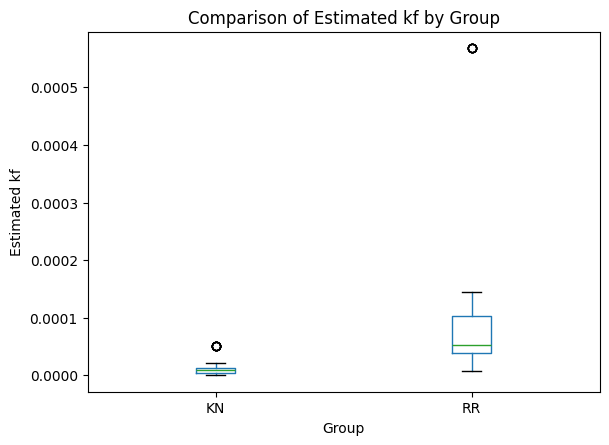

In [20]:
# Group data
rr_values = df_merged[df_merged['site'] == 'RR']['Frings et al. (2011)  [Estimated kf]']
kn_values = df_merged[df_merged['site'] == 'KN']['Frings et al. (2011)  [Estimated kf]']

# Kruskal-Wallis Test
stat, p_value = kruskal(rr_values, kn_values)

# Print test results
print(f"Kruskal-Wallis H-test result: H = {stat:.3f}, p = {p_value:.4f}")

# Boxplot
plt.figure(figsize=(8, 6))
df_merged.boxplot(
    column='Wooster et al. (2008) [Estimated kf]_slurp',
    by='site',
    grid=False
)
plt.title('Comparison of Estimated kf by Group')
plt.suptitle('')
plt.xlabel('Group')
plt.ylabel('Estimated kf')
plt.show()

In [7]:
rr_values.median()

0.000947046

In [8]:
kn_values.median()

0.001074077

Kruskal-Wallis H-test result: H = 10.194, p = 0.0014


<Figure size 800x600 with 0 Axes>

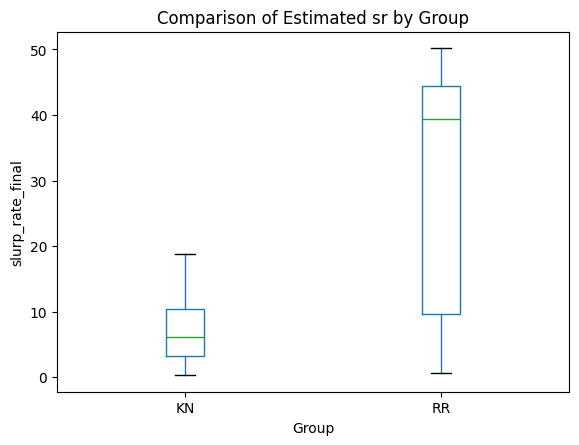

In [10]:
# Group data
df_surf = df_merged[df_merged['depth_sat_zone']<0.15]
rr_values = df_surf[df_surf['site'] == 'RR']['slurp_rate_final']
kn_values = df_surf[df_surf['site'] == 'KN']['slurp_rate_final']

# Kruskal-Wallis Test
stat, p_value = kruskal(rr_values, kn_values)

# Print test results
print(f"Kruskal-Wallis H-test result: H = {stat:.3f}, p = {p_value:.4f}")

# Boxplot
plt.figure(figsize=(8, 6))
df_surf.boxplot(
    column='slurp_rate_final',
    by='site',
    grid=False
)
plt.title('Comparison of Estimated sr by Group')
plt.suptitle('')
plt.xlabel('Group')
plt.ylabel('slurp_rate_final')
plt.show()

Kruskal-Wallis H-test result: H = 2.175, p = 0.1403


<Figure size 800x600 with 0 Axes>

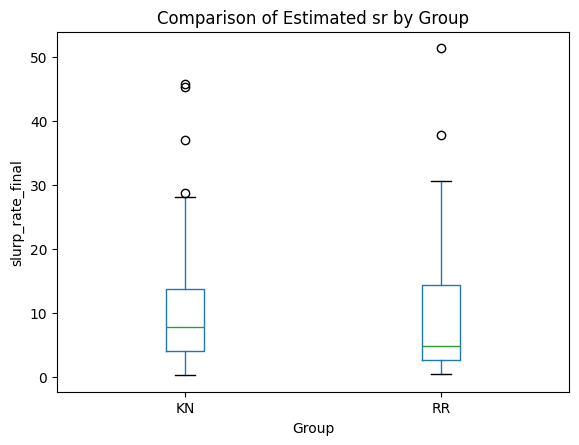

In [12]:
# Group data
df_subsurf = df_merged[df_merged['depth_sat_zone']>0.15]
rr_values = df_subsurf[df_subsurf['site'] == 'RR']['slurp_rate_final']
kn_values = df_subsurf[df_subsurf['site'] == 'KN']['slurp_rate_final']

# Kruskal-Wallis Test
stat, p_value = kruskal(rr_values, kn_values)

# Print test results
print(f"Kruskal-Wallis H-test result: H = {stat:.3f}, p = {p_value:.4f}")

# Boxplot
plt.figure(figsize=(8, 6))
df_subsurf.boxplot(
    column='slurp_rate_final',
    by='site',
    grid=False
)
plt.title('Comparison of Estimated sr by Group')
plt.suptitle('')
plt.xlabel('Group')
plt.ylabel('slurp_rate_final')
plt.show()